In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#import stuff from the mixture_composition_regression package
from mixture_composition_regression.examples.load_dipa_water_nacl_training_set import load_training_set
from mixture_composition_regression.cross_validation import cv_on_model_and_wavelength
from mixture_composition_regression.import_spectrum import clean_data
from mixture_composition_regression.sample import Sample
from mixture_composition_regression.mixture import Mixture
from mixture_composition_regression.preprocessor_pipeline import get_Xy
from mixture_composition_regression.gridsearch_dataset import grid_search_dataset

# import needed packages from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import os

In [2]:
# set the current working directory
cwd = '/Users/ianbillinge/dev/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/'
# cwd = '/Users/Ankit/projects/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/'

# read and clean the training spectra
file = os.path.join(os.sep, cwd, 'all_spectra.csv')
df = clean_data(file)

# read and clean target data (weight fraction).
w_file = os.path.join(os.sep, cwd, 'composition.csv')
composition = pd.read_csv(w_file)

# get a list of sample names
samples = np.array(composition.columns)[1:]

cp = {'name': ['cellulose', 'hemicellulose', 'lignin'],
      'mw': [1, 1, 1],
      'nu': [1, 1, 1]}

# create a list of Sample objects (one for each spectrum you collected)
ds = []
for s in samples:
    ds.append(Sample(s, df, x_col_name='wavenumber', a_col_name=s, 
                     chem_properties=cp, w=list(composition[s]/100.),
                    xbounds = [500, 3900]))

# create a mixture_composition_regression.Mixture object
# NOTE: I will probably remove the Mixture object from the package in the future, 
# and I do the regression without using the Mixture, but there are some plotting things that are quite nice.
mix = Mixture(ds)

Checking samples in mixture None


In [3]:
# create an xarray.Dataset object containing data on the absorption, 'a', and the first and second derivatives
# of the absorption, 'da', and 'd2a'.
da_list = [i.da for i in ds]
a = xr.combine_by_coords(da_list)
dataset = xr.Dataset(data_vars = {'a':a, 'da':a.diff('x'), 'd2a':a.diff('x', 2)})



# select whether you want to regress on raw spectral data or its derivatives.
# you can only select one.
# regressand = 'a' 
regressand = 'da'
# regressand = 'd2a'

# do a test-train split. Here we have specified a replicable random state, but this can be removed if you want
# a non-replicable one. You can also modify the portion of the data reserved for testing.
mix_train, mix_test = train_test_split(dataset[regressand], 
                                       test_size=0.2, 
                                       random_state=1
                                      )

Here, we initialize all of the different regressors we will try. The code will run GridSearchCV on all of them, basically going through and doing an exhaustive search on all the parameter options (e.g. Ridge regression with alpha = 10**(-7), then 10**(-6)... then 10**(7))

In [4]:
sc = 'neg_mean_absolute_error' # other scoring methods are available... 
                               # see anything under 'Regression' at scikit-learn.org/stable/modules/model_evaluation.html
cv_number = 5

In [5]:
ridge_param_grid = {'alpha': np.logspace(-7, 7, 14)}

ridge = GridSearchCV(
    Ridge(), 
    param_grid = ridge_param_grid, 
    scoring=sc, 
    cv=cv_number
)


kr_param_grid = {'kernel': ["rbf", 'linear'],
                "alpha": np.logspace(-7, 7, 11),
                "gamma": np.logspace(-7, 7, 11)
                }

kr = GridSearchCV(
    KernelRidge(),
    param_grid=kr_param_grid,
    scoring=sc,
    cv = cv_number
)

svr_param_grid = {'kernel': ['linear', 
#                              'rbf'
                            ],
     'gamma': ['scale', 'auto'],
     'epsilon': np.logspace(-7, 7, 10)
     }

svr = GridSearchCV(
    SVR(),
    param_grid=svr_param_grid,
    scoring=sc,
    cv = cv_number
)

knnr_param_grid = {'n_neighbors': 5 + np.arange(5)}
knnr = GridSearchCV(
    KNeighborsRegressor(), param_grid=knnr_param_grid, scoring=sc
)

mlp = GridSearchCV(
    MLPRegressor(solver='lbfgs', max_iter=400),
    param_grid = {'hidden_layer_sizes': [10, 50, 100]},
    scoring=sc,
    cv=cv_number
)

pls = GridSearchCV(
    PLSRegression(),
    param_grid = {'n_components': [2, 4, 6, 8]},
    scoring=sc,
    cv=cv_number

)

dtr = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid = {'max_depth': [2, 
#                                 3, 
#                                 5
                               ],
                  'min_samples_split': [2, 3]},
    scoring = sc,
    cv=cv_number
) # Decision tree regression is currently giving very good results... I am very worried that it is over-fitting.
# You can of course make the final call.

Decide the number of windows you want to break your spectrum into. If nwindows=1, the whole spectrum will be fed into the machine learning model.

If nwindows=10, the spectrum will be split into 10, and each sub spectrum will be fed into the machine learning model.

If nwindows is a list, the code will try all of them in sequence.

In [60]:
nwindows = [1, 
           5,
           10, 
            50, 
#             200
           ]

In [61]:
random_state = 1
# random_state = None # specify a replicable random split; this line can be set to None if not desired.
tts_size = 0.25 # reserve 1/4 of the data for testing.

# Specify a metric by which to compare models. Currently set to mean absolute error.
# Other metrics available at scikit-learn.org/stable/modules/model_evaluation.html

metric = mean_absolute_error
metric_label = 'MAE'

Specify the list of machine learning models you wish to consider.

In [62]:
cv_models = [
   ridge,
    pls,
   dtr,
   kr,
    svr,
    knnr,
    mlp,
]

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.09067033154719677
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on DecisionTreeRegressor()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on KernelRidge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.0623391706539478
Running analysis on SVR()
xbounds is 

xbounds is not a DataArray or Dataset.
xbounds: [1900.742 2249.742]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2250.8182 2599.8182]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2600.8944 2949.8944]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2950.9706 3299.9706]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.0468 3650.0468]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on PLSRegressio

xbounds is not a DataArray or Dataset.
xbounds: [1900.742 2249.742]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2250.8182 2599.8182]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2600.8944 2949.8944]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2950.9706 3299.9706]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.0468 3650.0468]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on MLPRegressor

xbounds is not a DataArray or Dataset.
xbounds: [2950.92705714 3019.92705714]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3020.94105306 3089.94105306]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3090.95504898 3159.95504898]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3160.9690449 3229.9690449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3230.98304082 3299.98304082]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3300.99703673 3369.99703673]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... F

xbounds is not a DataArray or Dataset.
xbounds: [3020.94105306 3089.94105306]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3090.95504898 3159.95504898]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3160.9690449 3229.9690449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3230.98304082 3299.98304082]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3300.99703673 3369.99703673]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3371.01103265 3440.01103265]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... F

xbounds is not a DataArray or Dataset.
xbounds: [3441.02502857 3510.02502857]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3511.03902449 3580.03902449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3581.05302041 3650.05302041]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.06701633 3720.06701633]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...

xbounds is not a DataArray or Dataset.
xbounds: [3371.01103265 3440.01103265]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3441.02502857 3510.02502857]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3511.03902449 3580.03902449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3581.05302041 3650.05302041]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.06701633 3720.06701633]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...

xbounds is not a DataArray or Dataset.
xbounds: [3441.02502857 3510.02502857]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3511.03902449 3580.03902449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3581.05302041 3650.05302041]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.06701633 3720.06701633]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...

xbounds is not a DataArray or Dataset.
xbounds: [3441.02502857 3510.02502857]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3511.03902449 3580.03902449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3581.05302041 3650.05302041]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.06701633 3720.06701633]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...

/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


xbounds is not a DataArray or Dataset.
xbounds: [1550.64713878 1619.64713878]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1620.66113469 1689.66113469]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1690.67513061 1759.67513061]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1760.68912653 1829.68912653]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1830.70312245 1899.70312245]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1900.71711837 1969.71711837]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...

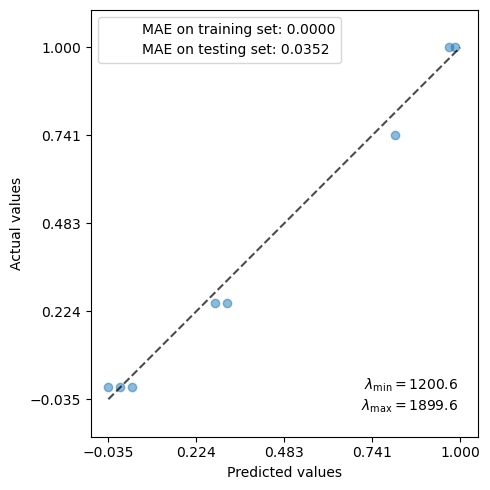

xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]


In [63]:
c_viable_models, c_bestmodel_container, c_y_best, c_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='cellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)


In [65]:
import time

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.07919516036666166
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on DecisionTreeRegressor()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on KernelRidge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on SVR()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
b

xbounds is not a DataArray or Dataset.
xbounds: [1900.742 2249.742]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2250.8182 2599.8182]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2600.8944 2949.8944]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2950.9706 3299.9706]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.0468 3650.0468]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on PLSRegressio

xbounds is not a DataArray or Dataset.
xbounds: [2950.9706 3299.9706]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.0468 3650.0468]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 849.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [ 850.5134 1199.5134]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1200.5896 1549.5896]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False Fals

xbounds is not a DataArray or Dataset.
xbounds: [3020.94105306 3089.94105306]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3090.95504898 3159.95504898]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3160.9690449 3229.9690449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3230.98304082 3299.98304082]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3300.99703673 3369.99703673]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3371.01103265 3440.01103265]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... F

xbounds is not a DataArray or Dataset.
xbounds: [3090.95504898 3159.95504898]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3160.9690449 3229.9690449]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3230.98304082 3299.98304082]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3300.99703673 3369.99703673]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3371.01103265 3440.01103265]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3441.02502857 3510.02502857]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... F

xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on KernelRidge()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [640.46519184 709.46519184]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False

xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on SVR()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False

xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on KNeighborsRegressor()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[F

xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [640.46519184 709.46519184]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [710.47918776 779.47918776]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [780.49318367 849.49318367]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [850.50717959 919.50717959]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [920.52117551 989.52117551]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False

xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]


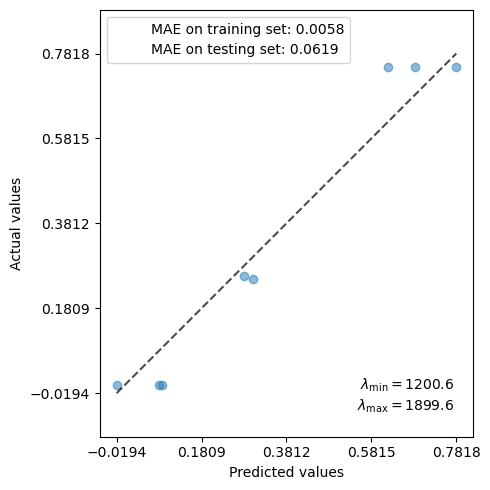

xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
-346.6806449890137


In [66]:
start = time.time()
h_viable_models, h_bestmodel_container, h_y_best, h_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='hemicellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(start-end)

In [67]:
#bestmodel_container

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.07919516036666166
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on DecisionTreeRegressor()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
we have a new best model!
current score: 0.059177777777777815
Running analysis on KernelRidge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
Running analysis on SVR()
xbounds i

/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Running analysis splitting interval into 5 windows.
Running analysis on Ridge()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 1199.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1200.60865 1899.60865]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1900.7801 2599.7801]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2600.95155 3299.95155]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on PLSRegression()
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 1199.4372]
bd

xbounds is not a DataArray or Dataset.
xbounds: [1550.6658 1899.6658]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1900.742 2249.742]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2250.8182 2599.8182]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2600.8944 2949.8944]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2950.9706 3299.9706]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.0468 3650.0468]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or 

xbounds is not a DataArray or Dataset.
xbounds: [1550.6658 1899.6658]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [1900.742 2249.742]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2250.8182 2599.8182]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2600.8944 2949.8944]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [2950.9706 3299.9706]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3301.0468 3650.0468]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or 

xbounds is not a DataArray or Dataset.
xbounds: [3581.05302041 3650.05302041]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3651.06701633 3720.06701633]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  Tr

xbounds is not a DataArray or Dataset.
xbounds: [3721.08101224 3790.08101224]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on DecisionTreeRegressor()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)


xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on KernelRidge()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [640.46519184 709.46519184]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [710.47918776 779.47918776]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False F

xbounds is not a DataArray or Dataset.
xbounds: [3791.09500816 3860.09500816]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on SVR()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [640.46519184 709.46519184]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False .

xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on KNeighborsRegressor()
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [640.46519184 709.46519184]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [710.47918776 779.47918776]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False

xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')
xbounds is not a DataArray or Dataset.
xbounds: [500.4372 569.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [570.45119592 639.45119592]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [640.46519184 709.46519184]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [710.47918776 779.47918776]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [780.49318367 849.49318367]
bds:
type: <class 'numpy.ndarray'>
sh

xbounds is not a DataArray or Dataset.
xbounds: [3861.10900408 3930.10900408]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ... False False False]
xbounds is not a DataArray or Dataset.
xbounds: [3931.123 4000.123]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False False False ...  True  True False]
xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]


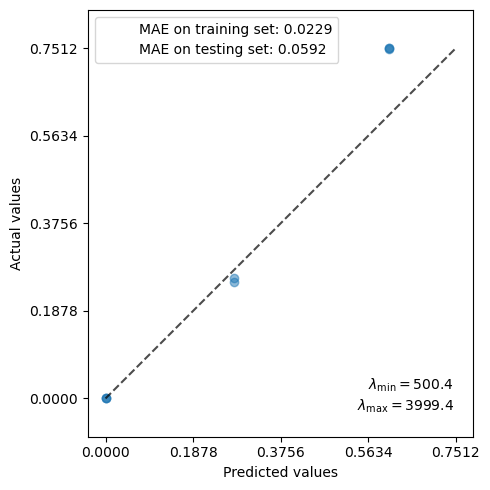

xbounds is not a DataArray or Dataset.
xbounds: [ 500.4372 3999.4372]
bds:
type: <class 'numpy.ndarray'>
shape: (7260,)
[False  True  True ...  True False False]
331.17720198631287


In [68]:
start = time.time()
l_viable_models, l_bestmodel_container, l_y_best, l_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='hemicellulose',
#     test_data=mix_test,
    test_data=None, # should be None if you want random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(end-start)

In [137]:
def predict_on_test_csvs(fpath, bestmodel_container, regressand, target, sample_name=None, print_sample=False, printres=False):
    new_data = pd.read_csv(fpath, 
#                        names=['wavenumber', 'absorbance'], 
                       header=0, # it was reading in the first row as data and causing problems. So I just had it read the column namese from the first row
                       dtype='float')  
    
    # renamed for less typing, but you can absolutely get rid of these column names and just rename to your preference
    new_data = new_data.rename(columns={new_data.columns[0]:'x', new_data.columns[1]:'y'}) 

    # because if you look higher in the code, we are currently regressing on the derivative of the data
    # so I calculated the derivative here
    if regressand == 'a':
        new_data[regressand] = new_data['y']
    if regressand == 'da':
        new_data[regressand] = new_data['y'].diff() 
    elif regressand == 'd2a':
        new_data[regressand] = new_data['y'].diff(order=2)


    # get the wavelength window we care about and slice the data, only keeping that stuff
    window = bestmodel_container[1] 
    new_data = new_data.where(new_data['x'] > window[0]).where(new_data['x'] < window[1]).dropna()
    new_data_dy = np.array(new_data[regressand]).reshape(1,-1)

    predictor = bestmodel_container[0]
    prediction = predictor.predict(new_data_dy)
    
    # discard unwanted nested lists
    for i in prediction.shape:
        prediction = prediction[0] 
        
    if print_sample is True:
        print('Sample: {}'.format(sample_name))
        
    if printres:
        print("predicted composition {} {:1.3f}".format(target, prediction))
    return prediction

In [144]:
fpaths = [i for i in os.listdir() if ('-' in i and ('.csv' in i or '.CSV' in i))]
c_list, h_list, l_list = [], [], []
sample_names = [i.split('.')[0] for i in fpaths]
for f, n in zip(fpaths, sample_names):
    c_list.append(predict_on_test_csvs(f, c_bestmodel_container, regressand, 'cellulose',sample_name=n, print_sample = True, printres=True))
    h_list.append(predict_on_test_csvs(f, h_bestmodel_container, regressand, 'hemicellulose',sample_name=n, printres=True))
    l_list.append(predict_on_test_csvs(f, l_bestmodel_container, regressand, 'lignin', sample_name=n, printres=True))



Sample: T2-1
predicted composition cellulose 0.339
predicted composition hemicellulose 0.111
predicted composition lignin 0.276
Sample: T2-3
predicted composition cellulose 0.173
predicted composition hemicellulose -0.042
predicted composition lignin 0.000
Sample: T2-2
predicted composition cellulose 0.257
predicted composition hemicellulose 0.085
predicted composition lignin 0.000
Sample: T4-1
predicted composition cellulose 0.203
predicted composition hemicellulose 0.295
predicted composition lignin 0.276
Sample: T4-3
predicted composition cellulose 0.061
predicted composition hemicellulose 0.146
predicted composition lignin 0.608
Sample: T4-2
predicted composition cellulose 0.120
predicted composition hemicellulose 0.242
predicted composition lignin 0.608
Sample: T3-3
predicted composition cellulose 0.257
predicted composition hemicellulose 0.343
predicted composition lignin 0.608
Sample: T1-1
predicted composition cellulose 0.428
predicted composition hemicellulose 0.492
predicted 

There is a problem, though. These do not sum up to anything close to 1. However, presumably we can compare between the model results and test values.

In [145]:
for c, h, l in zip(c_list, h_list, l_list):
    print(c + h + l)

0.7262219977593267
0.13139428941268183
0.34202273915684267
0.7741165211826722
0.8145284062335183
0.9701423643395236
1.2080820866191295
1.5284718303186609
1.3293740942612264
1.4321387303706676
1.3637677937444797
1.0299144715262618
0.49876565404832734
0.598274840826568
0.08229511900990244


### Save the trained models!

In [ ]:

import pickle

predictors = [c_bestmodel_container[0], h_bestmodel_container[0], l_bestmodel_container[0]]
predictor_ranges = [c_bestmodel_container[1], h_bestmodel_container[1], l_bestmodel_container[1]]

predictor_files = ['cellulose_predictor.pkl', 'hemi_predictor.pkl', 'lignin_predictor.pkl']
predictor_files = ['./trained_models/' + p for p in predictor_files]

for p, f in zip(predictors, predictor_files):
    with open(f, 'wb') as file:  
        pickle.dump(p, file)
        
predictor_metadata_files = [p.split('.')[0] + '_meta.txt' for p in predictor_files] 

for range, f in zip(predictor_ranges, predictor_metadata_files):
    with open(f, 'wb') as file:
        file.write(f)
